In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.9079.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.3287.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.222.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.12325.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.7717.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.2875.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.8644.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.8190.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.7804.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.12035.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.7153.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.2888.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.7275.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.3108.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.8388.jpg
/kaggle/input/dogs-vs-cats/dataset/vali

# Introduction

This notebook demonstrates how to build and train a deep learning model from scratch for the task of binary image classification using the Cats vs. Dogs dataset. The primary goal is to develop a convolutional neural network (CNN) that can accurately distinguish between images of cats and dogs.

Image classification is a foundational problem in computer vision with wide-ranging applications from autonomous driving to medical diagnostics. The Cats vs. Dogs dataset offers a perfect balance between simplicity and complexity: while the task of differentiating cats from dogs is intuitive, the dataset’s size and variability demand a sufficiently large and capable model. This makes it an ideal benchmark for developing, optimizing, and evaluating deep learning architectures.

This notebook is the first in a planned series of notebooks that together cover the full lifecycle of building efficient deep learning models. Future notebooks will explore:
- **Model pruning** to reduce model size and computational requirements without significant loss in accuracy.  
- **Knowledge distillation** to transfer learned knowledge from this larger “teacher” model to a smaller, more efficient “student” model.  
- **Quantization** to optimize the model for deployment on resource-constrained devices.  
- **Deployment** strategies for practical use cases.

The CNN architecture implemented here is designed to be both interpretable and sufficiently complex, serving as an ideal foundation for the optimization techniques discussed in the subsequent notebooks.

---


The Cats vs. Dogs dataset consists of three subsets:

- **Training set:** 20,000 images (10,000 cats and 10,000 dogs) with diverse poses, backgrounds, and lighting conditions.  
- **Validation set:** 5,000 images (2,500 cats and 2,500 dogs) used for hyperparameter tuning and intermediate evaluation.  
- **Test set:** 12,461 images (6,242 cats and 6,219 dogs) reserved for final evaluation on unseen data.

All images will be preprocessed by resizing and normalization to ensure consistency and stable training.

# Setup and Imports

In this section, we import the necessary libraries and configure the runtime environment. This includes setting random seeds for reproducibility and selecting the appropriate device (CPU or GPU) for model training.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tqdm

# pytorch essientials
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Enviornment configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Preprocessing and Loading

In this section, we prepare the dataset for training. This includes:

- Defining image transformations such as resizing, normalization, and data augmentation
- Loading the dataset using `ImageFolder`
- Creating DataLoaders for training, validation, and test sets

---

In [3]:
train_folder = "/kaggle/input/dogs-vs-cats/dataset/train"
val_folder = "/kaggle/input/dogs-vs-cats/dataset/validation"
test_folder = "/kaggle/input/dogs-vs-cats/dataset/test"

## Compute Dataset Mean and Standard Deviation

To normalize the dataset properly, we compute the channel-wise mean and standard deviation of the training set. This ensures the input distribution is centered and scaled, which stabilizes and speeds up training.

---

In [4]:
image_size = 224
batch_size = 64

In [5]:
temp_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

temp_dataset = datasets.ImageFolder(root=train_folder, transform=temp_transforms)
print(f"Classes: {temp_dataset.find_classes(train_folder)[1]}")
temp_dataloader = DataLoader(dataset=temp_dataset, batch_size=64)
print(type(temp_dataloader))

Classes: {'cats': 0, 'dogs': 1}
<class 'torch.utils.data.dataloader.DataLoader'>


In [6]:
def compute_mean_std(loader):
    n_images = 0 # the last batch might not be full we keep track of the number images
    mean = 0.
    std = 0.

    for images, _ in tqdm.tqdm(loader):
        batch_sample = images.size(0)
        images = images.view(batch_sample, images.size(1), -1) # this convers to(B, C, H*W)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_images += batch_sample

    mean = mean/n_images
    std = std/n_images
    return mean, std

In [7]:
mean, std = compute_mean_std(temp_dataloader)
print(f"mean: {mean.tolist()}, std: {std.tolist()}")

100%|██████████| 313/313 [03:10<00:00,  1.65it/s]

mean: [0.48826587200164795, 0.45505771040916443, 0.4168522357940674], std: [0.2254718691110611, 0.22077499330043793, 0.22099021077156067]


In [8]:
import json

# Convert tensors to list
stats = {
    'mean': mean.tolist(),
    'std': std.tolist()
}

# Save to file
with open('cats_dogs_norm_stats.json', 'w') as f:
    json.dump(stats, f)


# Data Preprocessing and Loading

In this section, we prepare the dataset for training. This includes:

- Defining image transformations such as resizing, normalization, and data augmentation
- Loading the dataset using `ImageFolder`
- Creating DataLoaders for training, validation, and test sets

---

In [9]:
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

transform_val = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

In [10]:
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_folder, transform=transform_val)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform_val)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [11]:
class_names = train_dataset.classes
print(class_names)

['cats', 'dogs']


## Visualize Sample Images

Before training, it's helpful to visualize some samples from the training set to verify image shapes, class balance, and augmentation effects.

---

In [12]:
def imshow(inp, ax, title=None):
    # Unnormalize
    if isinstance(mean, torch.Tensor):
        mean_tensor = mean.view(3, 1, 1)
        std_tensor = std.view(3, 1, 1)
    else:
        mean_tensor = torch.tensor(mean).view(3, 1, 1)
        std_tensor = torch.tensor(std).view(3, 1, 1)

    inp = inp.cpu() * std_tensor + mean_tensor  # unnormalize
    inp = inp.numpy().transpose((1, 2, 0))  # C x H x W → H x W x C
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

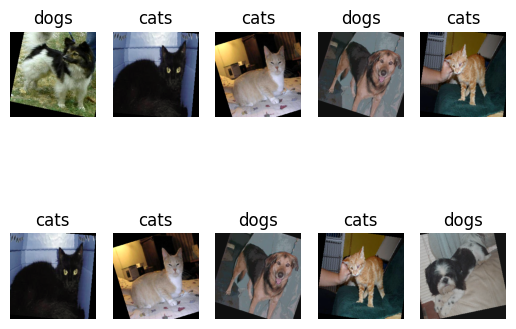

In [13]:
image = iter(train_dataloader)
image, label = next(image)
fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        imshow(image[i+j], axs[i, j],class_names[label[i+j]])

## Model Architecture

In this section, we define a custom Convolutional Neural Network (CNN) from scratch to solve the binary image classification task of distinguishing between cats and dogs.

This model is intentionally designed with enough depth and parameter complexity to make it a suitable candidate for future optimization techniques such as:
- **Pruning**
- **Knowledge Distillation**
- **Quantization**

These techniques will be explored in later notebooks as part of this project series.

---

### Why This Architecture?

The goal is to strike a balance between:
- **Simplicity** — so that the architecture is understandable and easy to analyze.
- **Complexity** — enough parameters and layers to allow for non-trivial learning and optimizations.

This CNN architecture contains:
- Multiple **convolutional layers** to extract features
- **Batch normalization** to stabilize and speed up training
- **ReLU activations** to introduce non-linearity
- **Max pooling layers** to reduce spatial dimensions
- **Dropout** for regularization
- **Fully connected layers** that map extracted features to a final binary classification output using a **sigmoid activation**

---